In [1]:
import json
import csv
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import numpy as np
import shutil
import os
from scipy.ndimage import gaussian_filter
import re

## 1. Preprocessing and filtage

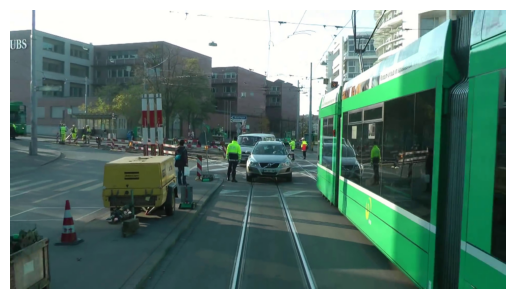

In [2]:
im0 = Image.open("../custom_images/0.jpg")

def get_size(image_size):
    #resizing an image while maintaining its aspect ratio within specified constraints
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

im0 = im0.resize(get_size(im0.size))

plt.axis("off")
plt.imshow(im0)
plt.show()

In [3]:
# VG 150 enitiy classes and 50 relationship classes.

CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra'] 

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

# Rule 1
class_risk_scores_r1 = {
    'N/A': 0, 'airplane': 3, 'animal': 4, 'arm': 0, 'bag': 0, 'banana': 0, 'basket': 0, 'beach': 0, 'bear': 5,
    'bed': 0, 'bench': 0, 'bike': 8, 'bird': 2, 'board': 0, 'boat': 3, 'book': 0, 'boot': 0, 'bottle': 0, 'bowl': 0,
    'box': 0, 'boy': 5, 'branch': 0, 'building': 0, 'bus': 8, 'cabinet': 0, 'cap': 0, 'car': 8, 'cat': 4, 'chair': 0,
    'child': 5, 'clock': 0, 'coat': 0, 'counter': 0, 'cow': 4, 'cup': 0, 'curtain': 0, 'desk': 0, 'dog': 4, 'door': 0,
    'drawer': 0, 'ear': 0, 'elephant': 5, 'engine': 4, 'eye': 0, 'face': 0, 'fence': 0, 'finger': 0, 'flag': 0, 'flower': 0,
    'food': 0, 'fork': 0, 'fruit': 0, 'giraffe': 4, 'girl': 5, 'glass': 0, 'glove': 0, 'guy': 5, 'hair': 0, 'hand': 0,
    'handle': 0, 'hat': 0, 'head': 0, 'helmet': 2, 'hill': 0, 'horse': 4, 'house': 0, 'jacket': 0, 'jean': 0, 'kid': 5,
    'kite': 0, 'lady': 5, 'lamp': 0, 'laptop': 0, 'leaf': 0, 'leg': 0, 'letter': 0, 'light': 0, 'logo': 0, 'man': 5,
    'men': 5, 'motorcycle': 6, 'mountain': 2, 'mouth': 0, 'neck': 0, 'nose': 0, 'number': 0, 'orange': 0, 'pant': 0,
    'paper': 0, 'paw': 0, 'people': 5, 'person': 5, 'phone': 0, 'pillow': 0, 'pizza': 0, 'plane': 3, 'plant': 2, 'plate': 0,
    'player': 0, 'pole': 0, 'post': 0, 'pot': 0, 'racket': 0, 'railing': 0, 'rock': 2, 'roof': 2, 'room': 0, 'screen': 0,
    'seat': 0, 'sheep': 4, 'shelf': 0, 'shirt': 0, 'shoe': 0, 'short': 0, 'sidewalk': 0, 'sign': 0, 'sink': 0, 'skateboard': 0,
    'ski': 0, 'skier': 0, 'sneaker': 0, 'snow': 0, 'sock': 0, 'stand': 0, 'street': 4, 'surfboard': 0, 'table': 0, 'tail': 0,
    'tie': 0, 'tile': 0, 'tire': 0, 'toilet': 0, 'towel': 0, 'tower': 3, 'track': 2, 'train': 8, 'tree': 0, 'truck': 8,
    'trunk': 0, 'umbrella': 0, 'vase': 0, 'vegetable': 0, 'vehicle': 8, 'wave': 0, 'wheel': 0, 'window': 0, 'windshield': 0,
    'wing': 0, 'wire': 0, 'woman': 5, 'zebra': 4
}

relation_risk_scores_r1 = {
    '__background__': 0, 'above': 2, 'across': 3, 'against': 0, 'along': 4, 'and': 0, 'at': 1, 'attached to': 4,
    'behind': 6, 'belonging to': 0, 'between': 2, 'carrying': 4, 'covered in': 3, 'covering': 5, 'eating': 0,
    'flying in': 4, 'for': 0, 'from': 0, 'growing on': 0, 'hanging from': 3, 'has': 0, 'holding': 0, 'in': 2,
    'in front of': 8, 'laying on': 2, 'looking at': 0, 'lying on': 2, 'made of': 0, 'mounted on': 3, 'near': 8,
    'of': 0, 'on': 5, 'on back of': 4, 'over': 3, 'painted on': 0, 'parked on': 5, 'part of': 0, 'playing': 2,
    'riding': 6, 'says': 0, 'sitting on': 2, 'standing on': 3, 'to': 0, 'under': 4, 'using': 0, 'walking in': 7,
    'walking on': 7, 'watching': 0, 'wearing': 0, 'wears': 0, 'with': 0
}

In [4]:
predict_json_path = "./json_outputs/custom_prediction.json"
data_info_json_path = "./json_outputs/custom_data_info.json"
imgs_dir='../custom_images'

In [5]:
def inference(image_index, im, predict_json_path, data_info_json_path, confidence=0.3,
                           class_risk_scores=class_risk_scores_r1, relation_risk_scores=relation_risk_scores_r1, filter=False, save_all_relations_png=False):
    # Load JSON data for predictions
    with open(predict_json_path) as file:
        custom_prediction = json.load(file)
    
    # Load JSON data for data info
    with open(data_info_json_path) as file:
        custom_data_info = json.load(file)

    ind_to_classes = custom_data_info['ind_to_classes']
    ind_to_predicates = custom_data_info['ind_to_predicates']
    
    # Prepare data for the specified image index
    image_data = custom_prediction[str(image_index)]
    boxes = image_data['bbox']
    box_labels = [ind_to_classes[label] for label in image_data['bbox_labels']]
    box_scores = image_data['bbox_scores']
    
    all_rel_labels = image_data['rel_labels']
    all_rel_scores = image_data['rel_scores']
    all_rel_pairs = image_data['rel_pairs']

    output_dir_name = './outputs'
    
    if save_all_relations_png:
        visul_rel_dir_name = os.path.join(output_dir_name,f'visual_relations_img{image_index}') 
        if not os.path.exists(visul_rel_dir_name):
            os.makedirs(visul_rel_dir_name)

    csv_path = os.path.join(output_dir_name,f'all_detected_relations_sgb_img{image_index}.csv')
    num_relation_detected = 0
    num_relation_filtered = 0
    # Open CSV file to write
    with open(csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Subject', 'Relationship', 'Object', 'Sub_bbox_xmin', 'Sub_bbox_ymin', 'Sub_bbox_xmax', 'Sub_bbox_ymax', 'Obj_bbox_xmin', 'Obj_bbox_ymin', 'Obj_bbox_xmax', 'Obj_bbox_ymax', 'risk_score_r1'])

        for i, pair in enumerate(all_rel_pairs):
            sub_idx, obj_idx = pair
            subject = box_labels[sub_idx]
            object = box_labels[obj_idx]
            relationship = ind_to_predicates[all_rel_labels[i]]
            
            # Filter by confidence threshold
            if all_rel_scores[i] >= confidence and box_scores[sub_idx]>= confidence and box_scores[obj_idx]>= confidence:
                
                sub_box = boxes[sub_idx]
                obj_box = boxes[obj_idx]
                sub_box = [int(np.round(x,0)) for x in sub_box]
                obj_box = [int(np.round(x,0)) for x in obj_box]
                # Placeholder for risk score calculation
                risk_score_r1 = np.round((class_risk_scores[subject]+relation_risk_scores[relationship]+class_risk_scores[object])/3, 2)
                if filter:
                    if class_risk_scores[subject]== 0 or class_risk_scores[object]==0 or subject==object:  #Filter out the the relationship who has entity with score 0 (We don't care 'banana near car')
                        num_relation_filtered+=1
                        continue
                    else:
                        num_relation_detected+=1 
                        writer.writerow([subject, relationship, object, *sub_box, *obj_box, risk_score_r1])
                else:
                    num_relation_detected+=1 
                    writer.writerow([subject, relationship, object, *sub_box, *obj_box, risk_score_r1])
                if save_all_relations_png:
                    # 为每个独特的关系生成和保存图片
                    figure_path = os.path.join(visul_rel_dir_name, f'relation_image_{i}.png')
                    fig, ax = plt.subplots(1)
                    ax.imshow(im)
                    ax.add_patch(plt.Rectangle((sub_box[0], sub_box[1]), sub_box[2] - sub_box[0], sub_box[3] - sub_box[1],
                                        fill=False, color='blue', linewidth=2.5))
                    ax.add_patch(plt.Rectangle((obj_box[0], obj_box[1]), obj_box[2] - obj_box[0], obj_box[3] - obj_box[1],
                                        fill=False, color='red', linewidth=2.5))
                    ax.axis('off')
                    relation_text = f'{subject} {object} {relationship}'
                    ax.set_title(relation_text, fontsize=10)
                    plt.savefig(figure_path)
                    plt.close()
    if filter:
        print(f"Generated and saved {num_relation_detected} relations for img{image_index} after {num_relation_filtered} relations filtered")
    else:
        print(f"Generated and saved {num_relation_detected} relations for img{image_index}")

In [6]:
inference(0, im0, predict_json_path, data_info_json_path, filter=True, save_all_relations_png= True)

Generated and saved 31 relations for img0 after 46 relations filtered


## 2. A Foundational Risk Evaluation Model
### 2.1 Risk Score Global

In [7]:
def calculate_risk_score_from_file(file_path):

    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Check if the DataFrame is empty
    if data.empty:
        return 0
    
    # Find the maximum value in the 'risk_score_r1' column
    max_risk_score = data['risk_score_r1'].max()
    
    return max_risk_score

In [8]:
csv_output_path = "./outputs/all_detected_relations_sgb_img0.csv"
risk_score = calculate_risk_score_from_file(csv_output_path)
print(f"Global risk score for the image: {risk_score}")

Global risk score for the image: 8.0


### 2.2 Risk Heatmap

In [9]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

In [10]:
def visualization_all_with_scores(csv_path, im, img_index, silence=False):
    # 读取CSV文件
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(16, 10))
    plt.imshow(im)

    # 绘制边界框和风险分数
    for index, row in df.iterrows():
        sub_bbox = [row['Sub_bbox_xmin'], row['Sub_bbox_ymin'], row['Sub_bbox_xmax'], row['Sub_bbox_ymax']]
        obj_bbox = [row['Obj_bbox_xmin'], row['Obj_bbox_ymin'], row['Obj_bbox_xmax'], row['Obj_bbox_ymax']]

        # 绘制主体边界框
        plt.gca().add_patch(plt.Rectangle((sub_bbox[0], sub_bbox[1]), sub_bbox[2] - sub_bbox[0], sub_bbox[3] - sub_bbox[1], linewidth=2, edgecolor='blue', facecolor='none'))
        # 绘制客体边界框
        plt.gca().add_patch(plt.Rectangle((obj_bbox[0], obj_bbox[1]), obj_bbox[2] - obj_bbox[0], obj_bbox[3] - obj_bbox[1], linewidth=2, edgecolor='red', facecolor='none'))

        # 标注风险分数
        plt.text(sub_bbox[0], sub_bbox[1], f"{row['risk_score_r1']:.2f}", color='white', fontsize=12, weight='light')

    plt.axis('off')
    plt.title("visualization_all_with_scores(SG_Benchmark)")
    plt.title(f"visualization_all_with_scores_img{img_index}(SG_Benchmark, conf=0.3)")
    plt.savefig(f"./outputs/visual_all_with_scores_img{img_index}_sgb.png")
    if silence:
        plt.close()
    else:
        plt.show()

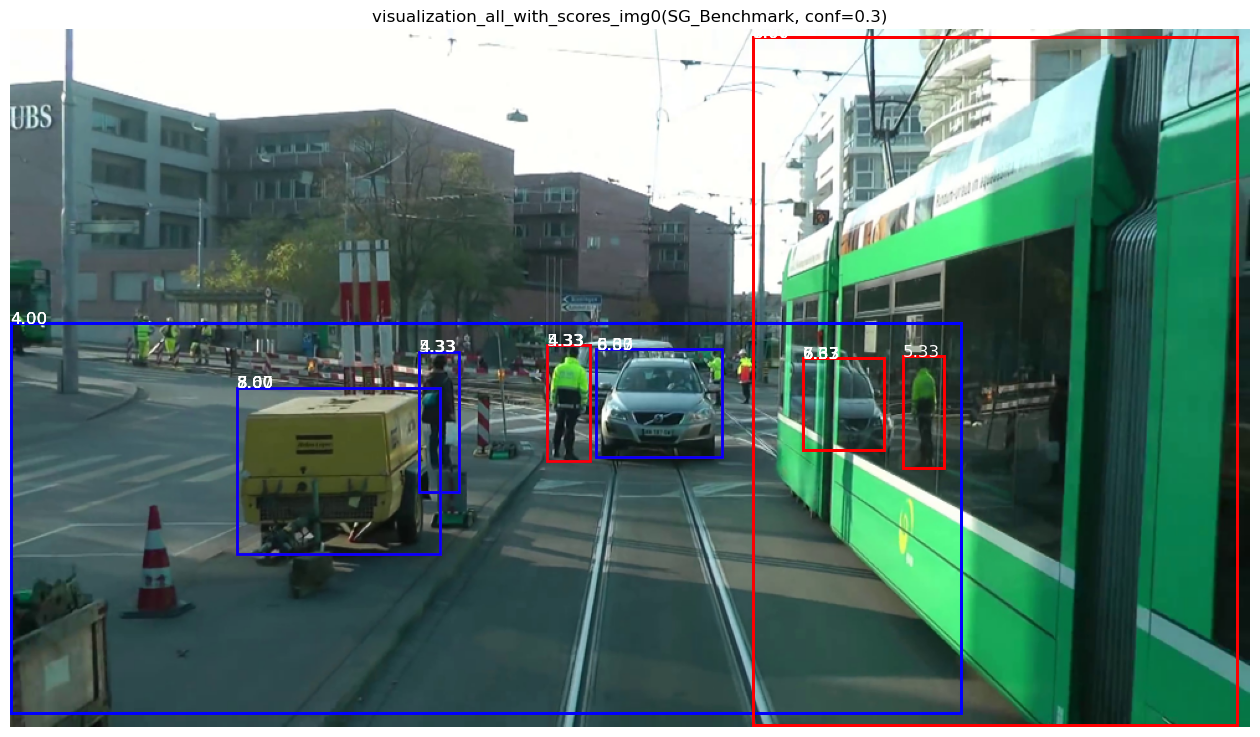

In [11]:

visualization_all_with_scores(csv_output_path, im0, img_index=0)

In [17]:
def keep_risky_entities(csv_path, im, img_index, silence =False):

    sub_or_obj = []
    Bbox_xmin = []
    Bbox_ymin = []
    Bbox_xmax = []
    Bbox_ymax = []
    risk_score = []

    # 读取CSV文件
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(16, 10))
    plt.imshow(im)

    def bbox_area(bbox):
        return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

    # 绘制边界框和风险分数
    for index, row in df.iterrows():
        sub_bbox = [row['Sub_bbox_xmin'], row['Sub_bbox_ymin'], row['Sub_bbox_xmax'], row['Sub_bbox_ymax'],row['Subject']]
        obj_bbox = [row['Obj_bbox_xmin'], row['Obj_bbox_ymin'], row['Obj_bbox_xmax'], row['Obj_bbox_ymax'],row['Object']]

        # 计算边界框面积
        sub_area = bbox_area(sub_bbox)
        obj_area = bbox_area(obj_bbox)

        # 选择面积较小的边界框
        smaller_bbox = sub_bbox if sub_area < obj_area else obj_bbox
        edge_color = 'red' if sub_area < obj_area else 'blue'

        Bbox_xmin.append(smaller_bbox[0])
        Bbox_ymin.append(smaller_bbox[1])
        Bbox_xmax.append(smaller_bbox[2])
        Bbox_ymax.append(smaller_bbox[3])
        sub_or_obj.append(smaller_bbox[4])
        risk_score.append(float(row['risk_score_r1']))

        # 绘制边界框
        plt.gca().add_patch(plt.Rectangle((smaller_bbox[0], smaller_bbox[1]), smaller_bbox[2] - smaller_bbox[0], smaller_bbox[3] - smaller_bbox[1], linewidth=2, edgecolor=edge_color, facecolor='none'))

        # 标注风险分数
        plt.text(smaller_bbox[0], smaller_bbox[1], f"{row['risk_score_r1']:.2f}", color='white', fontsize=12, weight='bold')

    plt.axis('off')
    plt.title(f"keep_only_potential_risky_bbox_img{img_index}(SG_Benchmark, conf=0.3)")
    plt.savefig(f"./outputs/keep_only_potential_risky_bbox_img{img_index}_sgb.png")
    if silence:
        plt.close()
    else:
        plt.show()

    #保存风险Bbox
    dir_name = "./outputs"
    file_name = f"keep_only_potential_risky_bbox_sgb_img{img_index}.csv"
    file_path = os.path.join(dir_name, file_name)
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Sub_or_Obj', 'Bbox_xmin', 'Bbox_ymin', 'Bbox_xmax', 'Bbox_ymax', 'risk_score_r1'])
        for i in range(len(sub_or_obj)):
            writer.writerow([sub_or_obj[i], Bbox_xmin[i], Bbox_ymin[i],Bbox_xmax[i], Bbox_ymax[i], risk_score[i]])

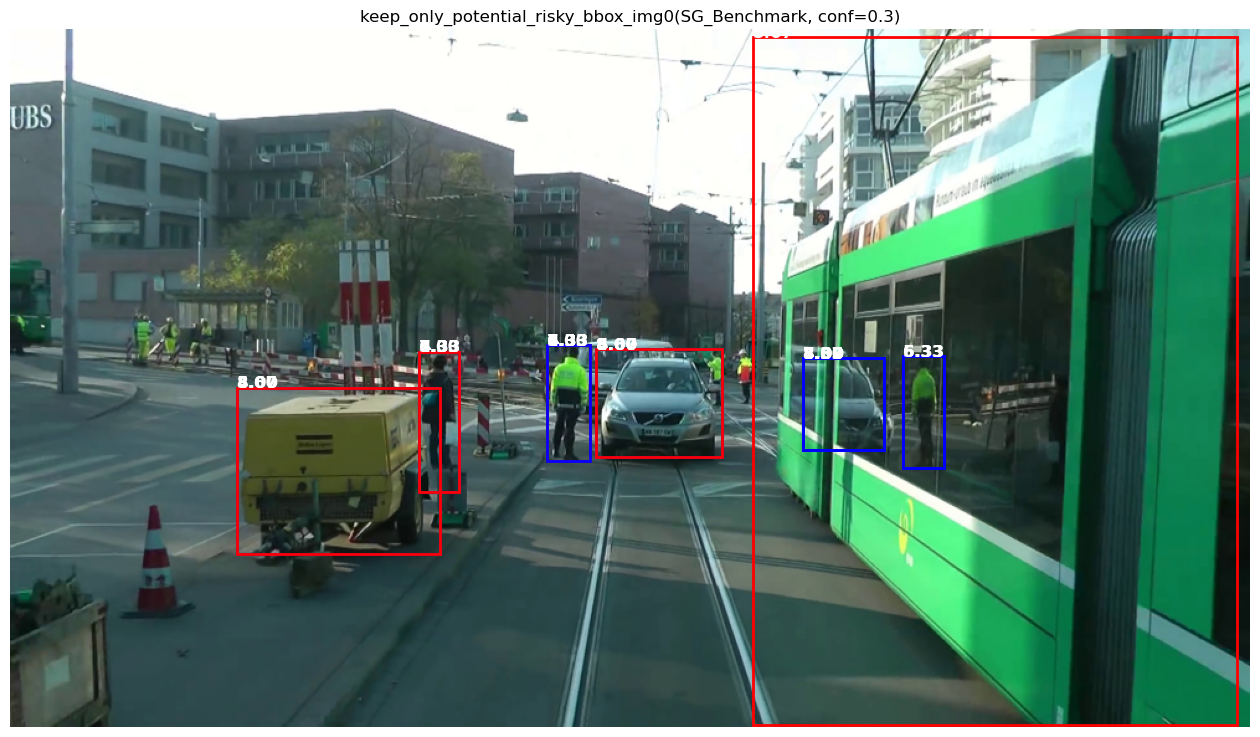

In [18]:
keep_risky_entities(csv_output_path,im0,0)

#### 2.2.1 Gaussian Heatmap

In [19]:
def create_gaussian_heatmap(csv_path, image, img_index, sigma, silence=False):

    image = np.array(image)
    image_shape =image.shape
    df = pd.read_csv(csv_path)

    # Initialize a heatmap to zeros
    heatmap = np.zeros(image_shape[:2])
    
    # Loop through the dataframe and add Gaussian blobs for each bounding box
    for index, row in df.iterrows():
        # Calculate the center of the bounding box
        center_x = int((row['Bbox_xmin'] + row['Bbox_xmax']) / 2)
        center_y = int((row['Bbox_ymin'] + row['Bbox_ymax']) / 2)
        risk_score = row['risk_score_r1']
        
        # Assuming that the center is within the bounds of the image
        if center_x >= 0 and center_y >= 0 and center_x < image_shape[1] and center_y < image_shape[0]:
            heatmap[center_y, center_x] = risk_score  # Set the risk score at the center

    # Apply a Gaussian filter to blur the heatmap
    gaussian_heatmap = gaussian_filter(heatmap, sigma=sigma) *1e4   #for values between 1-10

    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    
    # Overlay the heatmap
    plt.imshow(gaussian_heatmap, cmap='jet', alpha=0.5)
    plt.title(f'gaussian_risk_heatmap_SG_Benchmark_img{img_index}(conf=0.3, sigma={sigma})')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f"./outputs/gaussian_risk_heatmap_SG_Benchmark_img{img_index}.png")
    if silence:
        plt.close()
    else:
        plt.show()

    return gaussian_heatmap

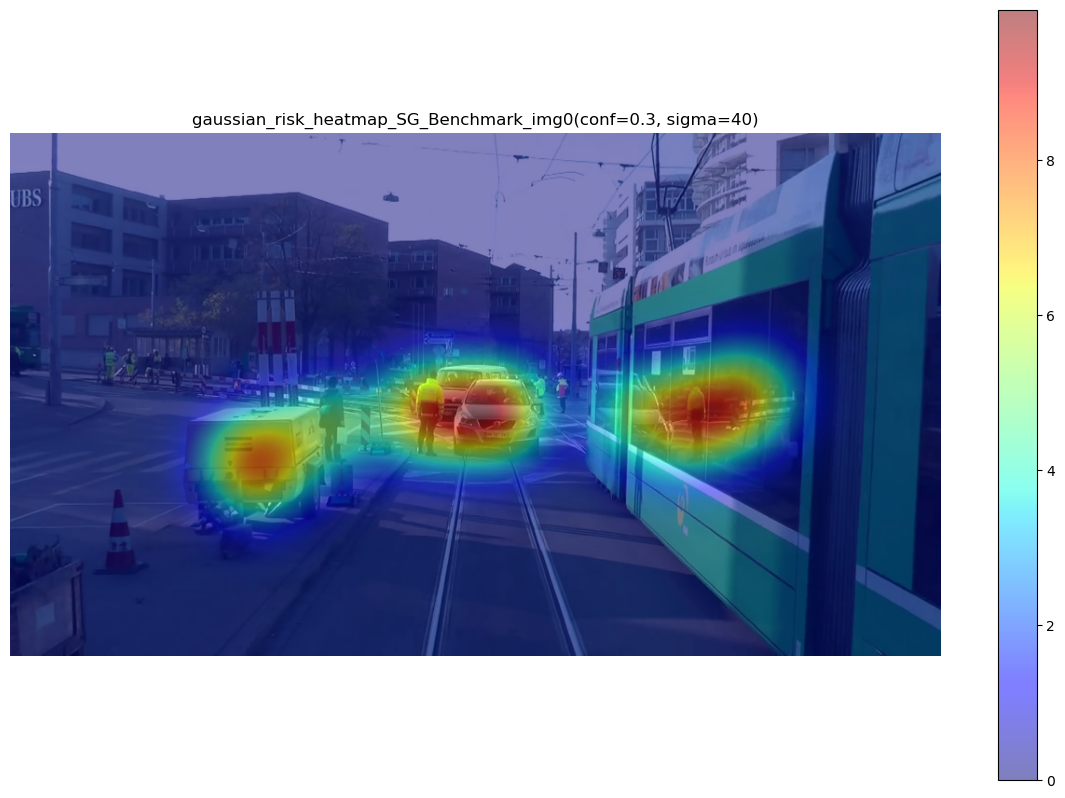

In [20]:
gaussian_heatmap = create_gaussian_heatmap("./outputs/keep_only_potential_risky_bbox_sgb_img0.csv", im0, img_index=0, sigma=40)

#### 2.2.1 Cumulative Heatmap

In [21]:
# Function to create the cumulative heatmap
def create_cumulative_heatmap(csv_path, im, img_index, silence=False):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    im_array = np.array(im)

    # Create an empty heatmap with the same dimensions as the image
    heatmap = np.zeros((im_array.shape[0], im_array.shape[1]))

    # Iterate through the CSV rows and add the risk score to the heatmap
    for _, row in df.iterrows():
        bbox = (row['Bbox_xmin'], row['Bbox_ymin'], row['Bbox_xmax'], row['Bbox_ymax'])
        risk_score = row['risk_score_r1']
        # add the risk scores to the heatmap matrix
        x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        heatmap[y_min:y_max, x_min:x_max] += risk_score

    # Display the original image
    plt.figure(figsize=(15, 10))
    plt.imshow(im)

    # Overlay the heatmap
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f'cumulative_risk_heatmap_SG_Benchmark_img{img_index}(conf=0.3)')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f"./outputs/cumulative_risk_heatmap_SG_Benchmark_img{img_index}.png")
    if silence:
        plt.close()
    else:
        plt.show()
    
    return heatmap

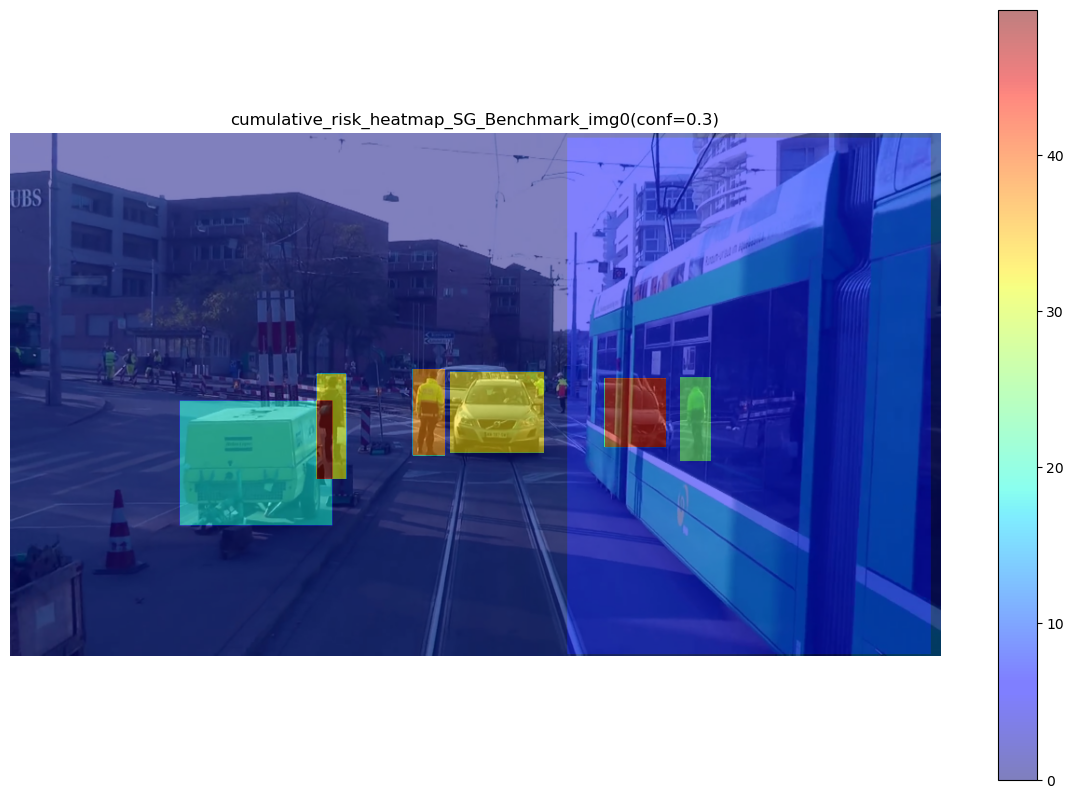

In [22]:
cumulative_heatmap = create_cumulative_heatmap("./outputs/keep_only_potential_risky_bbox_sgb_img0.csv",im0, img_index=0)

## 3. Inference And Risk Heatmaps Generation For All Custom Images

In [23]:
def clean_outputs_dir():
    dir_name='./outputs'
    # 确保目录存在
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # 获取目录中的所有文件和文件夹
    files = os.listdir(dir_name)

    # 遍历目录中的所有文件和文件夹
    for file in files:
        file_path = os.path.join(dir_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)  # 删除文件
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 递归删除文件夹及其内容
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")

In [24]:
def all(imgs_dir, predict_json_path, data_info_json_path, class_risk_scores=class_risk_scores_r1, 
        relation_risk_scores=relation_risk_scores_r1, confidence=0.3, sigma=40):
    
    im_list = []
    #gaussian_heatmap_list = []
    #cumulative_heatmap_list = []
    
    def sort_numerically(filename):
        """
        This function extracts the numerical part of the filename and returns it as an integer.
        """
        numbers = re.findall(r'\d+', filename)
        return int(numbers[0]) if numbers else 0
    
    for filename in sorted(os.listdir(imgs_dir), key=sort_numerically):
        file_path = os.path.join(imgs_dir, filename)
        with Image.open(file_path) as im:
            im = im.resize(get_size(im.size))
            im_list.append(im.copy())
    
    clean_outputs_dir()  #clean outputs dir

    global_score_file_path = "./outputs/global_risk_score_for_custom_imgs.csv"
    with open(global_score_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Img_name', 'Global_score'])
        
        for i, im in enumerate(im_list):
            im_name = "img" + str(i)
            print("===========================================================")
            print(f"Start Inference And Risk Heatmaps Generation For img{i}")
            print("===========================================================")
            inference(i, im, predict_json_path, data_info_json_path, confidence,
                            class_risk_scores, relation_risk_scores, filter=True)
            print(f'all_detected_relations_img{i}_sgb.csv is saved.')
            csv_all_file_path = os.path.join('./outputs', f'all_detected_relations_sgb_img{i}.csv')
            risk_score = calculate_risk_score_from_file(csv_all_file_path)
            writer.writerow([im_name, risk_score])
            visualization_all_with_scores(csv_all_file_path, im, i, silence=True)
            print(f"visual_all_with_scores_img{i}_SGB.png is saved.")
            keep_risky_entities(csv_all_file_path, im, i, silence=True)
            print(f"keep_only_potential_risky_bbox_img{i}_SGB.png is saved.")
            print(f"keep_only_potential_risky_bbox_img{i}_SGB.csv is saved.")
            csv_keep_file_path = os.path.join('./outputs', f"keep_only_potential_risky_bbox_sgb_img{i}.csv")
            gaussian_heatmap = create_gaussian_heatmap(csv_keep_file_path, im, i, sigma, silence=True)
            #gaussian_heatmap_list.append(gaussian_heatmap)
            print(f"gaussian_risk_heatmap_SGB_img{i}.png is saved.")
            cumulative_heatmap = create_cumulative_heatmap(csv_keep_file_path, im, i, silence=True)
            #cumulative_heatmap_list.append(cumulative_heatmap)
            print(f'cumulative_risk_heatmap_SGB_img{i}.png is saved')
            print(f"\nEnd For img{i}\n\n")
    print(f"global_risk_score.csv is saved.")
    print("All processes have been completed and all outputs saved successfully!") 
    #return gaussian_heatmap_list, cumulative_heatmap_list

In [25]:
all(imgs_dir, predict_json_path, data_info_json_path)

Start Inference And Risk Heatmaps Generation For img0
Generated and saved 31 relations for img0 after 46 relations filtered
all_detected_relations_img0_sgb.csv is saved.
visual_all_with_scores_img0_SGB.png is saved.
keep_only_potential_risky_bbox_img0_SGB.png is saved.
keep_only_potential_risky_bbox_img0_SGB.csv is saved.
gaussian_risk_heatmap_SGB_img0.png is saved.
cumulative_risk_heatmap_SGB_img0.png is saved

End For img0


Start Inference And Risk Heatmaps Generation For img1
Generated and saved 23 relations for img1 after 104 relations filtered
all_detected_relations_img1_sgb.csv is saved.
visual_all_with_scores_img1_SGB.png is saved.
keep_only_potential_risky_bbox_img1_SGB.png is saved.
keep_only_potential_risky_bbox_img1_SGB.csv is saved.
gaussian_risk_heatmap_SGB_img1.png is saved.
cumulative_risk_heatmap_SGB_img1.png is saved

End For img1


Start Inference And Risk Heatmaps Generation For img2
Generated and saved 0 relations for img2 after 0 relations filtered
all_detected_re

In [26]:
def only_save_global_risk_score_for_all(num_images,predict_json_path, data_info_json_path, global_score_file_path, class_risk_scores=class_risk_scores_r1, 
        relation_risk_scores=relation_risk_scores_r1, confidence=0.3):

    with open(global_score_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Img_name', 'Global_score'])
        for i in range(num_images):
            im_name = "img" + str(i)
            inference(i, None, predict_json_path, data_info_json_path, confidence,
                            class_risk_scores, relation_risk_scores, filter=True)
            csv_all_file_path = os.path.join('./outputs', f'all_detected_relations_sgb_img{i}.csv')
            risk_score = calculate_risk_score_from_file(csv_all_file_path)
            writer.writerow([im_name, risk_score])
    
    print("All processes have been completed and csv saved successfully!")

In [14]:
clean_outputs_dir()

for i in range(1,7):
    predict_json_path = f"./json_outputs_{i}/custom_prediction.json"
    data_info_json_path = f"./json_outputs_{i}/custom_data_info.json"
    global_score_file_path = f"./outputs/global_score_for_rs19_sgb_{i}.csv"
    if i==6:
        only_save_global_risk_score_for_all(331,predict_json_path, data_info_json_path, global_score_file_path)
    else:
        only_save_global_risk_score_for_all(500,predict_json_path, data_info_json_path, global_score_file_path)

Generated and saved 0 relations for img0 after 15 relations filtered
Generated and saved 0 relations for img1 after 30 relations filtered
Generated and saved 0 relations for img2 after 16 relations filtered
Generated and saved 0 relations for img3 after 24 relations filtered
Generated and saved 0 relations for img4 after 4 relations filtered
Generated and saved 4 relations for img5 after 17 relations filtered
Generated and saved 3 relations for img6 after 28 relations filtered
Generated and saved 0 relations for img7 after 1 relations filtered
Generated and saved 6 relations for img8 after 17 relations filtered
Generated and saved 0 relations for img9 after 10 relations filtered
Generated and saved 0 relations for img10 after 20 relations filtered
Generated and saved 4 relations for img11 after 24 relations filtered
Generated and saved 0 relations for img12 after 8 relations filtered
Generated and saved 2 relations for img13 after 26 relations filtered
Generated and saved 0 relations f

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001CC59761C10>>
Traceback (most recent call last):
  File "c:\Users\tjsim\anaconda3\envs\rp\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Generated and saved 0 relations for img3 after 15 relations filtered


## 5. Global Risk Score Accuracy

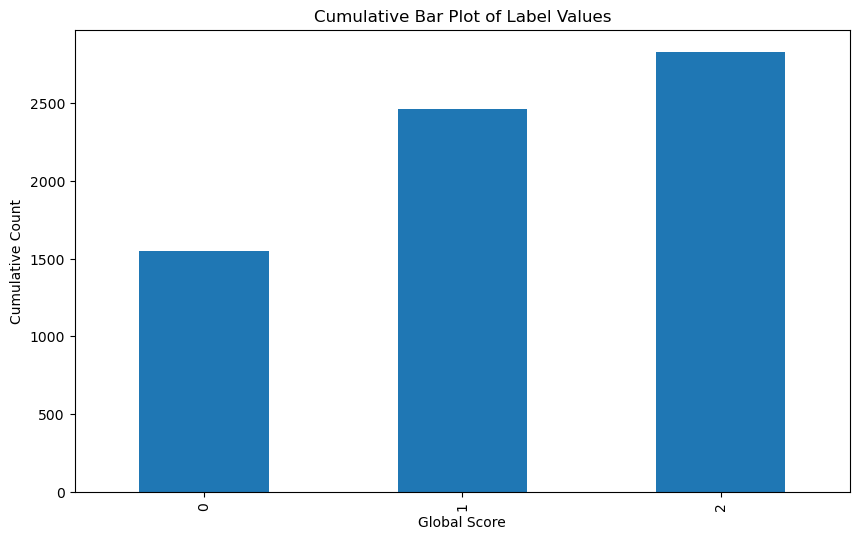

In [30]:
label_csv_path = "../labels.csv"
label_data = pd.read_csv(label_csv_path, sep=';',names=['Name','General_risk(0-1-2)','Weather[0-10]',
                                                        'Light[0-10]','Users[0-10]','Context[0-10]'],skiprows=1).iloc[:2831]
label_values = label_data['General_risk(0-1-2)']
label_value_counts = label_values.value_counts().sort_index()

# Plot cumulative bar plot
plt.figure(figsize=(10, 6))
label_value_counts.cumsum().plot(kind='bar')
plt.xlabel('Global Score')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Bar Plot of Label Values')
plt.show()

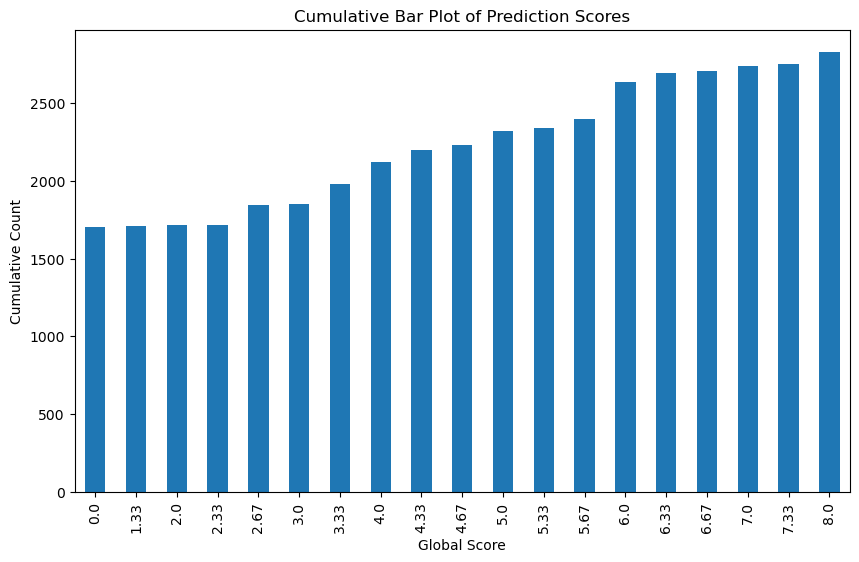

In [41]:
prediction_csv_path_1 = './outputs/global_score_for_rs19_sgb_1.csv'
prediction_csv_path_2 = './outputs/global_score_for_rs19_sgb_2.csv'
prediction_csv_path_3 = './outputs/global_score_for_rs19_sgb_3.csv'
prediction_csv_path_4 = './outputs/global_score_for_rs19_sgb_4.csv'
prediction_csv_path_5 = './outputs/global_score_for_rs19_sgb_5.csv'
prediction_csv_path_6 = './outputs/global_score_for_rs19_sgb_6.csv'

# path 1: 0-499, 2: 500-999, 3: 1000-1499, 4: 1500-1999, 5: 2000-2380

# Load the prediction data
pred_data_1 = pd.read_csv(prediction_csv_path_1, names=['Img_name', 'Global_score'], skiprows=1)
pred_data_2 = pd.read_csv(prediction_csv_path_2, names=['Img_name', 'Global_score'], skiprows=1)
pred_data_3 = pd.read_csv(prediction_csv_path_3, names=['Img_name', 'Global_score'], skiprows=1)
pred_data_4 = pd.read_csv(prediction_csv_path_4, names=['Img_name', 'Global_score'], skiprows=1)
pred_data_5 = pd.read_csv(prediction_csv_path_5, names=['Img_name', 'Global_score'], skiprows=1)
pred_data_6 = pd.read_csv(prediction_csv_path_6, names=['Img_name', 'Global_score'], skiprows=1)

prediction_values_1 = pred_data_1['Global_score']
prediction_values_2 = pred_data_2['Global_score']
prediction_values_3 = pred_data_3['Global_score']
prediction_values_4 = pred_data_4['Global_score']
prediction_values_5 = pred_data_5['Global_score']
prediction_values_6 = pred_data_6['Global_score']

prediction_values = pd.concat([prediction_values_1, prediction_values_2, prediction_values_3, prediction_values_4, prediction_values_5, prediction_values_6], ignore_index=True)
# Get counts for each unique value
pred_value_counts = prediction_values.value_counts().sort_index()

# Plot cumulative bar plot
plt.figure(figsize=(10, 6))
pred_value_counts.cumsum().plot(kind='bar')
plt.xlabel('Global Score')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Bar Plot of Prediction Scores')
plt.show()

In [37]:
label_value_counts.cumsum()

General_risk(0-1-2)
0    1547
1    2462
2    2831
Name: count, dtype: int64

In [38]:
pred_value_counts.cumsum()

Global_score
0.00    1706
1.33    1709
2.00    1713
2.33    1714
2.67    1844
3.00    1853
3.33    1982
4.00    2123
4.33    2198
4.67    2231
5.00    2320
5.33    2342
5.67    2395
6.00    2635
6.33    2696
6.67    2709
7.00    2740
7.33    2749
8.00    2831
Name: count, dtype: int64

In [60]:
# <=4.33   --> 0
# >4.33 <=6   -->1
# >6   -->2

def apply_thresholds(score, thresholds):
    if score <= thresholds[0]:
        return 0
    elif score <= thresholds[1]:
        return 1
    else:
        return 2

# Define the thresholds
thresholds = [4.33, 6]

# Normalize the prediction scores based on the thresholds
normalized_pred_scores = prediction_values.apply(lambda x: apply_thresholds(x, thresholds))

In [61]:
# Calculate the accuracy
accuracy = np.mean(normalized_pred_scores == label_values)
accuracy

0.5920169551395267